In [105]:
from memoization import memoize_to_folder

In [106]:
from scapy.all import *
import sys
import numpy as np
import os

KEYLEN=8

@memoize_to_folder('memo/pcaps2')
def read_pcap2(out_dir):
    pcfs = [os.path.join(out_dir, 'moongen', 'moongen_in.pcap'),
            os.path.join(out_dir, 'moongen', 'moongen_out.pcap')]
    
    n_sets = [0]
    n_misses = [0]
    n_gets = [0]
    n_values = [0]
    gets = defaultdict(list)
    vals = defaultdict(list)
    
    for pcf in pcfs:
        f = open(pcf, 'rb')
        print("Reading {}".format(pcf))
        pcap=dpkt.pcap.Reader(f)
        for ts, buf in pcap:
            try:
                eth=dpkt.ethernet.Ethernet(buf)
                ip=eth.data
                tcp = ip.data
                spkt = tcp.data
            except Exception as e:
                print("Exception parsing packet {} : {}".format(buf, e))
                continue

            try: 
                get_start = spkt.find(b'get ')
                if get_start >= 0:
                    key = spkt[:2] + spkt[get_start+4:get_start+4+KEYLEN]
                    gets[key].append(ts)
                    n_gets[0] += 1
                    if n_gets[0] % 5000 == 0:
                        print('{}th get'.format(n_gets[0]))
                    continue
                val_start = spkt.find(b'VALUE ')
                if val_start >= 0:
                    key = spkt[:2] + spkt[val_start+6:val_start+6+KEYLEN]
                    vals[key].append(ts)
                    n_values[0] += 1
                    if n_values[0] % 5000 == 0:
                        print("{}th value".format(n_values[0]))
                    continue
                if b'set ' in spkt:
                    n_sets[0] += 1
                    if n_sets[0] % 2000 == 0:
                        print('{}th set'.format(n_sets[0]))
                elif b'STORED' in spkt:
                    continue
                elif b'END' in spkt:
                    n_misses[0] += 1
                else:
                    print('Unknown packet load: {}'.format(spkt))
            except AttributeError as e:
                print("Exception reading payload from {}: {}".format(buf, e))
        
    print("Got {} sets".format(n_sets[0]))
    print("Got {} values".format(n_values[0]))
    
    print("Got {} explicit misses".format(n_misses[0]))
    print("Read pcap file")
    return gets, vals

def read_rate_file(out_dir):
    ratefile = os.path.join(out_dir, 'pktgen.log')
    try:
        with open(ratefile) as f:
            ratestr = f.read()
    except:
        return 0
    if not ratestr.startswith('Rate: '):
        raise Exception("Could not read rate string")
    rate = int(ratestr.strip("Rate: "))
    return rate

def read_experiment(directory, recalculate=False):
    print( "Reading from directory {}".format(directory))
    return read_pcap2(directory, __recalculate=recalculate), read_rate_file(directory)

In [107]:
import itertools

def best_drop_tds(vtimes, gtimes, both_drops=0):
    vtimes = np.array(vtimes)
    gtimes = np.array(gtimes)
    lendiff = len(gtimes) - len(vtimes)
    maxlen = max(len(gtimes), len(vtimes))
    minlen = min(len(gtimes), len(vtimes))
    
    n_gdrops = max(-lendiff, 0)
    n_vdrops = max(lendiff, 0)
    
    if n_gdrops == 0 and n_vdrops == 0:
        tdiffs = vtimes - gtimes
        tds = []
        for td, gd in zip(tdiffs, gtimes):
            if not np.isnan(td) and td > 0:
                tds.append((gd, td))
        return tds        
    
    if n_gdrops != 0:
        print( "Missing GET")
        
        drop_locs = []
        max_drop = 0
        
        for n_g in range(n_gdrops):
            v_cut = vtimes[: minlen + n_g + 1]
            min_std = None
            min_std_drop_locs = None
            
            for i in range(max_drop, len(v_cut)):
                this_drop_locs = drop_locs[:]
                this_drop_locs.append(i)
                
                this_gtimes = gtimes[:]
                for drop_loc in this_drop_locs:
                    this_gtimes = np.insert(this_gtimes, drop_loc, np.nan)
                
                tdiffs = v_cut - this_gtimes
                tdiffs = tdiffs[~np.isnan(tdiffs)]
                if any(tdiffs < 0):
                    continue
                this_std = np.std(tdiffs)
                
                if min_std is None or this_std < min_std:
                    min_std = this_std
                    min_std_drop_locs = this_drop_locs
                    
            if min_std is None:
                return []
            drop_locs = min_std_drop_locs if min_std_drop_locs is not None else [0] + drop_locs
            max_drop = max(drop_locs)
    
        gdrops = gtimes[:]
        for drop_loc in drop_locs:
            gdrops = np.insert(gdrops, drop_loc, np.nan)
        tdiffs = vtimes - gdrops
        tds = []
        for td, gd in zip(tdiffs, gdrops):
            if not np.isnan(td):
                tds.append((gd, td))
        return tds

    if n_vdrops != 0:
        
        drop_locs = []
        max_drop = 0
        
        for n_v in range(n_vdrops):
            g_cut = gtimes[: minlen + n_v + 1]
            min_std = None
            min_std_drop_locs = None
            
            for i in range(max_drop, len(g_cut)):
                this_drop_locs = drop_locs[:]
                this_drop_locs.append(i)
                
                this_vtimes = vtimes[:]
                for drop_loc in this_drop_locs:
                    this_vtimes = np.insert(this_vtimes, drop_loc, np.nan)
                
                tdiffs = this_vtimes - g_cut
                tdiffs = tdiffs[~np.isnan(tdiffs)]
                if any(tdiffs < 0):
                    continue
                this_std = np.std(tdiffs)
                
                if min_std is None or this_std < min_std:
                    min_std = this_std
                    min_std_drop_locs = this_drop_locs
                    
            if min_std is None:
                return []
            drop_locs = min_std_drop_locs if min_std_drop_locs is not None else [0] + drop_locs
            max_drop = max(drop_locs)
    
        vdrops = vtimes[:]
        for drop_loc in drop_locs:
            vdrops = np.insert(vdrops, drop_loc, np.nan)
        tdiffs = vdrops - gtimes
        tds = []
        for td, vd in zip(tdiffs, vdrops):
            if not np.isnan(td):
                tds.append((vd, td))
        return tds         
    
def get_success_percent(gets, values):
    return float(sum(len(v) for v in values.values())) / float(sum(len(g) for g in gets.values()))

def get_tds(gets, values, threshold=None):
    print("Getting TDs")
    tds = []
    min_gtime = min(min(x) for x in gets.values())
    missing_values = []
    drops = 0
    for k, vtimes in values.items():
        if k not in gets:
            missing_values.extend(values[k])
            continue
        vtimes = np.array(vtimes)
        gtimes = np.array(gets[k])
        lendiff = len(gtimes) - len(vtimes)
        
        if len(vtimes) == 1 and len(gtimes) == 1:
            tds.append((gtimes[0], vtimes[0] - gtimes[0]))
        else:

            new_tds = best_drop_tds(vtimes, gtimes)
            tds.extend(new_tds)
        
            drops += abs(len(new_tds) - max(len(vtimes), len(gtimes)))
      
    print("Missing {} gets".format(len(missing_values)))
    print("{} drops noticed".format(drops))
    print("{} drops total".format(sum(len(g) for g in gets.values()) - sum(len(v) for v in values.values())))
    print("{} tds".format(len(tds)))
    print(tds[:10])
    return np.array(tds)

def experiment_success_rate(directory):
    (gets, vals), rate = read_experiment(directory)
    return get_success_percent(gets, vals), rate, min(gets.values()), max(max(vals.values()), max(gets.values()))

@memoize_to_folder("memo/tds")
def experiment_tds(directory, recalculate=False):
    (gets, vals), rate = read_experiment(directory, recalculate=recalculate)
    return get_tds(gets, vals), rate, sum(len(g) for g in gets.values())

In [108]:
from glob import glob
import time
import re
from multiprocessing import Pool as ThreadPool 

def experiment_tds_wrapper(arg):
    start = time.time()
    try:
        print("Running {}".format(arg))
        rtn = experiment_tds(arg)
        end = time.time()
        if rtn is None:
            rtn = experiment_tds(arg, __recalculate=True)
        print("Completed {} in {}s".format(arg, end - start))
        return rtn, arg
    except Exception as e:
        print("Did not complete {}!!!! {}".format(arg, e))
        return None
        
def dictize(d):
    d = copy.deepcopy(d)
    for k in d.keys():
        if isinstance(d[k], defaultdict):
            d[k] = dictize(d[k])
    return dict(d)

def load_all_experiments(toptopdir='inputs', depth=1, poolsize=5):
    d = toptopdir
    rec_dd = lambda : defaultdict(rec_dd)
    experiments = defaultdict(rec_dd)
    
    directories = glob(os.path.join(toptopdir, '*'))
    for i in range(depth):
        new_directories = []
        for subdir in directories:
            new_directories.extend(glob(os.path.join(subdir, '*')))
        directories = new_directories
        
    pool = ThreadPool(poolsize)
    results = pool.map(experiment_tds_wrapper, directories)
    pool.close()
    pool.join()
    results = [ x for x in results if x is not None]
        
    for (tds, rate, ngets), directory in results:
        split_dir = directory.split('/')
        keys = []
        for part in split_dir:
            if part not in toptopdir:
                for key in keys:
                    part = part.replace(key, '')
                    part = part.strip('_')
                keys.append(part)
        
        experiment = experiments
        for key in keys[:-1]:
            experiment = experiment[key]
        experiment[keys[-1]] = rate, tds, ngets
    
    return dictize(experiments)
            
    #experiments[subsub][subdir] = load_all_experiments(d)

    #return dict(experiments)

In [109]:
# load_all_experiments('../tc7_output', depth=0, poolsize=8)

In [38]:
# baseline_files= glob('../output_swap/new_baseline_*')
# baseline_mcd = [ experiment_tds(x, __recalculate=True) for x in baseline_files ]
# t_files = glob('../output_swap/new_t_*')
# t_mcd = [ experiment_tds(x) for x in t_files ]
# c_files = glob('../output_swap/new_c_[12]*')
# c_mcd = [ experiment_tds(x) for x in c_files ]
# tc_files = glob('../output_swap/new_tc_*')
# tc_mcd = [ experiment_tds(x) for x in tc_files ]
# tdc_files = glob('../output_swap/new_tdc_*')
# tdc_mcd = [ experiment_tds(x) for x in tdc_files ]
# tdcf_files = glob('../output_swap/new_tdcf_*')
# tdcf_mcd = [ experiment_tds(x) for x in tdcf_files ]
# tdcfk_files = glob('../output_swap/new_tdcfk_*')
# tdcfk_mcd = [ experiment_tds(x) for x in tdcfk_files ]

# mcd = [baseline_mcd, t_mcd, c_mcd, tdc_mcd, tdcf_mcd, tdcfk_mcd]
# mcd_labels = 'Baseline', '+Telemetry', '+HC','+Drop','+FEC','+KV'

In [39]:
from collections import OrderedDict
from glob import glob

tc7_globs = OrderedDict((
    ('Baseline', '../tc7_output/tc7_base_*'),
    ('+HC', '../tc7_output/tc7_c_*'),
    ('+Drop', '../tc7_output/tc7_cd_*'),
    ('+FEC', '../tc7_output/tc7_cdf_*'),
    ('+KV', '../tc7_output/tc7_cdfk_*')
))
tc7_files = OrderedDict(
    [(k, glob(v)) for k, v in tc7_globs.items()]
)

In [40]:
mcd_data = OrderedDict(
    (k, [experiment_tds(x) for x in glob(v)]) for k, v in tc7_globs.items()
)

Loading from memo/tds/experiment_tds__directory-tc7_outputtc7_base_5.pickle
:: Cached stdout:
 :: Reading from directory ../tc7_output/tc7_base_5 :: 
 :: Reading ../tc7_output/tc7_base_5/moongen/moongen_in.pcap :: 
 :: 2000th set :: 
 :: 4000th set :: 
 :: 6000th set :: 
 :: 8000th set :: 
 :: 10000th set :: 
 :: 5000th get :: 
 :: 10000th get :: 
 :: 15000th get :: 
 :: 20000th get :: 
 :: 25000th get :: 
 :: 30000th get :: 
 :: 35000th get :: 
 :: 40000th get :: 
 :: 45000th get :: 
 :: 50000th get :: 
 :: 55000th get :: 
 :: 60000th get :: 
 :: 65000th get :: 
 :: 70000th get :: 
 :: 75000th get :: 
 :: 80000th get :: 
 :: 85000th get :: 
 :: 90000th get :: 
 :: 95000th get :: 
 :: 100000th get :: 
 :: 105000th get :: 
 :: 110000th get :: 
 :: 115000th get :: 
 :: 120000th get :: 
 :: 125000th get :: 
 :: 130000th get :: 
 :: 135000th get :: 
 :: 140000th get :: 
 :: 145000th get :: 
 :: 150000th get :: 
 :: 155000th get :: 
 :: 160000th get :: 
 :: 165000th get :: 
 :: 170000th get

In [41]:
%matplotlib notebook
import matplotlib.pyplot as plt

def filter_tds(tds, percentile):
    return tds[tds[:,1] < np.percentile(tds[:,1], percentile)]

def get_rolling_timeseries(tds):
    tds = tds[:]
    tds[:,0] -= min(tds[:,0])
    
    x = []
    y1 = []
    y2 = []
    
    for start in range(0, int(max(tds[:,0]) * 10), 10):
        start /= 10.0
        relevant = tds[(tds[:,0] > start) & (tds[:,0] < start + .1)][:,1]
        x.append(start)
        y1.append(np.median(relevant) * 1e6)
    return np.array(x) - 5, y1
       
def plot_rolling_timeseries(tds, label=None):
    x, y = get_rolling_timeseries(tds)
#     plt.plot(x, y1, '.-', label=label )
    plt.plot(x, y, '.-', label=label )
    plt.xlim([1, 9])
    

def plot_timeseries(tds, label=None, gets=None, percentile=100):
    times, diffs = filter_tds(tds, percentile).T
    scaled_times = (times - min(times))# (times - min(times)) / (max(times) - min(times))
    plt.plot(scaled_times, diffs * 1000000, '.', markersize=1, alpha=.1, label=label)
    
def plot_histogram(tds, label):
    times, diffs = filter_tds(tds, 100).T
    diffs *= 1000000
    plt.hist(diffs, alpha=.7, bins=np.arange(100.0)/2 - .25, label=label)

<IPython.core.display.Javascript object>


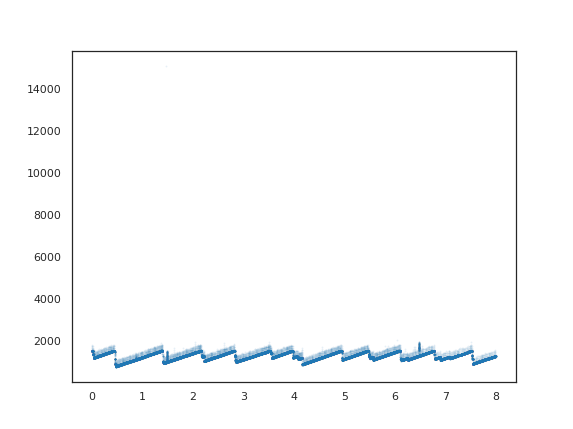

In [42]:
plt.figure()
# plot_timeseries(tc7_data['Baseline'][0][0])
# plot_timeseries(tc7_data['+HC'][0][0])
# plot_timeseries(tc7_data['+5% Drop'][0][0])
# plot_timeseries(mcd_data['+HC'][4][0])
plot_timeseries(iperf_only(mcd_data['Baseline'][0][0]))

In [595]:
def rolling_data(tds):
    tds = tds[:]
    tds[:,0] -= min(tds[:,0])
    
    rolling = []
    step = 2
    
    for start in range(0, int(max(tds[:,0]) * 10), step):
        start /= 10.0
        relevant = tds[(tds[:,0] > start) & (tds[:,0] < start + step / 10.0)]
        rolling.append(relevant)
    return rolling[:int(200 / step)]


def summarize(experiment, percentiles):
    return np.array([np.percentile(experiment[:,1], p) for p in percentiles])
       
def rolling_summary(tds, percentiles):
    rolling = rolling_data(tds)
    summaries = []
    for roll in rolling:
        summaries.append(summarize(roll, percentiles))
    summaries = np.array(summaries)
    return summaries

def rolling_summarize_all(groups, percentiles = [1, 25, 50, 75, 99]):
    summaries = {}
    for group, experiments in groups.items():
        summaries[group] = np.array([rolling_summary(e[0], percentiles) for e in experiments])
    return summaries
        
def summarize_all(groups, percentiles = [1,25,50,75,99]):
    summaries = {}
    for group, experiments in groups.items():
        summaries[group] = np.array([summarize(e[0], percentiles) for e in experiments])
    return summaries

def make_grouped_mcd_ts(groups, labels):
        
    grid = Grid(plt.gcf(), rect=111, nrows_ncols=(1,len(groups)),
            axes_pad=.05, label_mode='L',
            )    
        
#     ax = plt.subplot(1, len(grouped), 1) 
    for i, (ax, group, label) in enumerate(zip(grid,groups, labels)):
#         ax = plt.subplot(1, len(grouped), i+1, sharey=ax)
        plt.sca(ax)
        for td in group:
            plot_rolling_timeseries(td[0])
        ax.set_title(label)

def iperf_only(arr):
    arr[:,0]-= min(arr[:,0])
    return arr[(arr[:,0]>6) & (arr[:,0] < 14)]
        
def get_violin_data(groups):
    
    x = []
    y = []
    
    for group, datas in groups.items():
        x.append(group)
        yy = np.array([])
        for data in datas:
            yy = np.append(yy, filter_tds(iperf_only(data[0]),100)[:,1] * 1e6)
        y.append(yy)
    
    return x, y
    

<IPython.core.display.Javascript object>


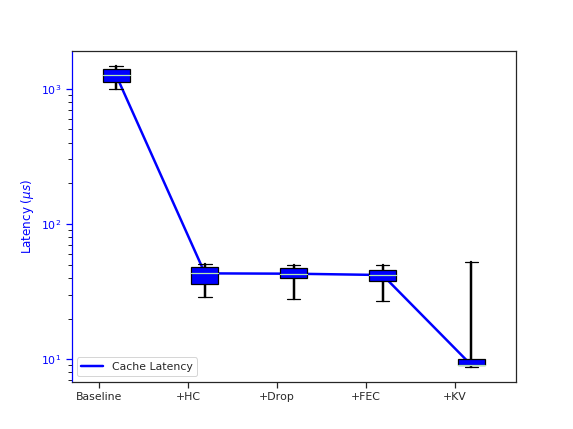

In [172]:
mcdx, mcdy= get_violin_data(mcd_data)
sns.set_style('ticks')

WIDTH=.38

def boxplot(ax, data, pos, facecolor, linecolor, textfile, line='-'):
    pl = ax.plot(pos, [np.median(y) for y in data], line, color=facecolor, linewidth=2, zorder=1)
    bp = ax.boxplot(data, positions=pos, widths=WIDTH*.8,showfliers=False, patch_artist=True, whis=[10,90], boxprops=dict(facecolor=facecolor), whiskerprops=dict(linewidth=2),medianprops=dict(color=linecolor), zorder=10)
    plt.xticks(pos-WIDTH/2)
    ax.set_xticklabels(mcdx)
    if textfile:
        with open(textfile,'w') as f:
            f.write("ft.\t10%\t25%\t50%\t75%\t90%\n")
            for x, y in zip(mcdx, data):
                f.write("{}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\n"
                        .format(x, *[np.percentile(y, p) for p in [10,25,50,75,90]]))
    return pl
    
def make_mcd_violinplot(ax, color_labels=True, textfile=None):
    pos = np.arange(len(mcdx)) - WIDTH/2.5
#     parts = ax.violinplot(mcdy, positions=pos,points=1000,widths=WIDTH*2, showmeans=False, showmedians=True, showextrema=False)
    
#     c = 'b'
    c = 'b'
    parts = boxplot(ax, mcdy, pos,c, [.7,.9,.7], textfile)

    
    
        # change fill color

#     for part in parts['bodies']:
#         part.set_facecolor([0,0,.6])
#         part.set_alpha(1)
        
#     parts['cmedians'].set_color([.7, .7, 1])
    

    ax.legend(parts, ['Cache Latency'], loc='lower left')
    
    ax.set_ylabel(r"Latency ($\mu s$)", color=c if color_labels else 'k')
    ax.yaxis.set_label_position('left')
    ax.yaxis.tick_left()
    if color_labels:
        plt.setp(ax.get_yticklabels(), color=c)
        ax.tick_params(axis='y', colors=c)
        ax.spines['left'].set_color(c)
    ax.set_yscale('log')
    

plt.figure()
make_mcd_violinplot(plt.subplot(), True, 'mcd_e2e.txt')

In [173]:

def read_iperf_ts_directory(directory):
    try:
        event_log = json.load(open(os.path.join(directory, 'event_log.json')))
        dp_start = [e for e in event_log if e['name_'] == 'dataplane'][0]
        drop_rate = float(dp_start['drop_rate'])
    except IOError:
        print("{} Event log not found".format(directory))
        return None, None
    
    g = glob(directory + '/iperf/client_*.json')
    if len(g) == 0:
        return None, None
    
    all_points = defaultdict(list)
    
    for file in g:
        try:
            j = json.load(open(file))
        except Exception as e:
            print("Malformed json {}: {}".format(file, e))
            try:
                lines = '\n'.join(open(file).readlines()[1:])
                j = json.loads(lines)
                print("Retry succeeded")
            except Exception as e2:
                print("Retry also failed: {}".format(e2))
                continue
        i=-1
        for i, interval in enumerate(j['intervals']):
            all_points[i].append(interval['sum']['bits_per_second'])
            if all_points[i][-1] / DIV > 5000:
                print(file) 
        if i != 9:
            print("{}: {} intervals".format(file, i+1))
    
    sums = []
    for i in range(len(all_points)):
        sums.append(sum(all_points[i]) / DIV)
        
    return sums
    
def get_iperf_data(groups):
    
    x = []
    y = []
    
    for group, dirs in groups.items():
        x.append(group)
        yy = np.array([])
        for dir in dirs:
            yy = np.append(yy, read_iperf_ts_directory(dir))
        y.append(yy)
        
        
    return x, y

In [169]:
iperfx, iperfy= get_iperf_data(tc7_files)

def make_iperf_violinplot(ax, color_labels=True, textfile=None):
    x = np.arange(len(iperfx)) + WIDTH/2.5
    
#   c = [.3,0,0]
    c = 'r'
    
    parts = boxplot(ax, iperfy, x, c, [1,1,0], textfile, line='--')
    
#     parts = ax.violinplot(iperfy, positions=x, widths=WIDTH*2, showmeans=False, showmedians=True, showextrema=False)
#     for part in parts['bodies']:
#         part.set_facecolor([.9,.4,.4])
#         part.set_alpha(1)    
#     parts['cmedians'].set_color([.5, 0, 0])
#     ax.plot(x, [np.median(y) for y in iperfy], '.-',color=[.8,.2,.2], markersize=10)

    ax.legend(parts, ['Iperf Throughput'],loc='upper right')

  
    
    ax.set_ylabel('Throughput (Gbps)', color=c if color_labels else 'k')
    ax.set_yscale('linear')
    
    ax.yaxis.set_label_position('right')
    ax.yaxis.tick_right()
    
    if color_labels:
        plt.setp(ax.get_yticklabels(), color=c)
        ax.tick_params(axis='y', colors=c)
        ax.spines['right'].set_color(c)
    return parts


../tc7_output/tc7_cd_1/iperf/client_6.json: 0 intervals
../tc7_output/tc7_cd_2/iperf/client_1.json: 0 intervals
Malformed json ../tc7_output/tc7_cd_3/iperf/client_8.json: Expecting value: line 1 column 1 (char 0)
Retry succeeded
../tc7_output/tc7_cd_3/iperf/client_8.json: 9 intervals
../tc7_output/tc7_cd_4/iperf/client_5.json: 0 intervals
../tc7_output/tc7_cdf_4/iperf/client_2.json: 0 intervals
../tc7_output/tc7_cdfk_4/iperf/client_5.json: 0 intervals
../tc7_output/tc7_cdfk_1/iperf/client_2.json: 0 intervals
../tc7_output/tc7_cdfk_1/iperf/client_4.json: 0 intervals
Malformed json ../tc7_output/tc7_cdfk_2/iperf/client_7.json: Expecting value: line 1 column 1 (char 0)
Retry succeeded
../tc7_output/tc7_cdfk_2/iperf/client_7.json: 9 intervals


<IPython.core.display.Javascript object>


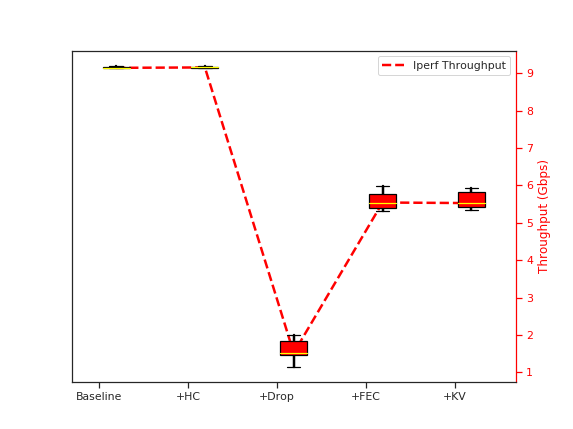

In [174]:
plt.figure()
make_iperf_violinplot(plt.subplot(), True, 'iperf_e2e.txt')

<IPython.core.display.Javascript object>


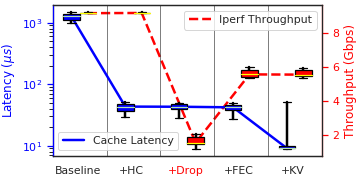

[9.147155617096345, 9.15767396619378, 1.521402189319537, 5.544514267324969, 5.5295045131503056]
[1260.0421905517578, 43.15376281738281, 42.91534423828125, 41.961669921875, 9.059906005859375]


In [183]:
import os
plt.gray()
sns.set_context('paper')
def make_twin_plot(color_labels=False):
    sns.set_style("white")
    
    ax = plt.subplot()
    ax.set_yscale('log')
    
    ax2 = plt.twinx()
    make_mcd_violinplot(ax2)
    make_iperf_violinplot(ax)
    
    for x in .5, 1.5, 2.5, 3.5:
        ax.axvline(x, color=[.2,.2,.2], linewidth=.5)
        
    ax.set_xlim([-.5,4.5])
    
    print([np.median(yy) for yy in iperfy])
    print([np.median(yy) for yy in mcdy])
    ax.get_xticklabels()[2].set_color([1,0,0]) 
    

plt.figure(figsize=(4,2))
make_twin_plot()
plt.tight_layout(pad=.1)

plt.savefig("e2e.pdf") 

def make_gray(infile, outfile):
    os.system('rm -f {}; \
              gs \
    -sOutputFile="{}" \
    -sDEVICE=pdfwrite \
    -sColorConversionStrategy=Mono \
    -sColorConversionStrategyForImages=/Mono \
    -dProcessColorModel=/DeviceGray \
    -dCompatibilityLevel=1.3 \
    -dNOPAUSE -dBATCH \
    "{}"'.format(outfile, outfile, infile))

make_gray('e2e.pdf', './e2e_gray.pdf')



In [236]:
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import sys
import argparse
import os
from collections import defaultdict

DIV=1e9

sns.set_style('whitegrid')

def read_iperf_ts_directory(directory):
    try:
        event_log = json.load(open(os.path.join(directory, 'event_log.json')))
        dp_start = [e for e in event_log if e['name_'] == 'dataplane'][0]
        drop_rate = float(dp_start['drop_rate'])
    except IOError:
        print("{} Event log not found".format(directory))
        return None, None
    
    g = glob(directory + '/iperf/client_*.json')
    if len(g) == 0:
        return None, None
    
    all_points = defaultdict(list)
    
    for file in g:
        try:
            j = json.load(open(file))
        except Exception as e:
            print("Malformed json {}: {}".format(file, e))
            try:
                lines = '\n'.join(open(file).readlines()[1:])
                j = json.loads(lines)
                print("Retry succeeded")
            except Exception as e2:
                print("Retry also failed: {}".format(e2))
                continue
        i=-1
        for i, interval in enumerate(j['intervals']):
            all_points[i].append(interval['sum']['bits_per_second'])
            if all_points[i][-1] / DIV > 5000:
                print(file) 
        if i != 9:
            print("{}: {} intervals".format(file, i+1))
    
    sums = []
    for i in range(len(all_points)):
        sums.append(sum(all_points[i]) / DIV)
        
    return sums
    

def read_directory(directory):
    total_bps = 0
    total_i = 0

    try:
        event_log = json.load(open(os.path.join(directory, 'event_log.json')))
        dp_start = [e for e in event_log if e['name_'] == 'dataplane'][0]
        drop_rate = float(dp_start['drop_rate'])
    except IOError:
        print("{} Event log not found".format(directory))
        return None, None

    g = glob(directory + '/client_*.out')
    if len(g) == 0:
        g = glob(directory + '/iperf/client_*.json')
    if len(g) == 0:
        return None, None

    for file in g:
        try:
            j = json.load(open(file))
            if 'sum_received' in j['end']:
                bps = j['end']['sum_sent']['bits_per_second']
            elif 'sum' in j['end']:
                bps = j['end']['sum']['bits_per_second']
            else:
                raise Exception("No sum or sum_sent")
        except Exception as e:
            print('error', file, e)
            continue
        total_bps += bps
        total_i += 1

    if total_bps == 0:
        return None, None

    print('{}({}): {} Mbps'.format(directory, total_i, total_bps / DIV ))

    return drop_rate, total_bps / DIV

        
def make_iperf_timeseries(folders, color=None):
    used_labels=set()
    
    for folder in folders:
        ts = read_iperf_ts_directory(folder)

        x = np.arange(len(ts))
        
        plt.plot(x, ts, '.-', color=color)
    

def make_mean_and_error(vals):
    mean = np.median(vals)
    lowerr = mean - min(vals)
    higherr = max(vals) - mean

    return mean, (lowerr, higherr)

def make_iperf_barplot(fecs, no_fecs, title=None, sv=None):

    fec_by_rate = defaultdict(list)
    nofec_by_rate = defaultdict(list)

    for dir in fecs:
        r, val = read_directory(dir)
        if r is not None:
            fec_by_rate[r].append(val)

    for dir in no_fecs:
        r, val = read_directory(dir)
        if r is not None:
            nofec_by_rate[r].append(val)

    if len(fec_by_rate) != len(nofec_by_rate):
        print("WARNING: {} fec, {} nofec".format(len(fec_by_rate), len(nofec_by_rate)))

    rates, base_vals, base_errs, fec_vals, fec_errs =  \
            [], [], [], [], []

    for rate in sorted(set(fec_by_rate.keys()) | set(nofec_by_rate.keys())):
        
        
        rates.append(rate)

        if rate in fec_by_rate:
            m, e = make_mean_and_error(fec_by_rate[rate])
        else:
            m, e = 0, 0
                
        fec_vals.append(m)
        fec_errs.append(e)

        if rate in nofec_by_rate:
            m, e = make_mean_and_error(nofec_by_rate[rate])
        else:
            m, e = 0, 0

        base_vals.append(m)
        base_errs.append(e)

    x = np.arange(len(rates))
    fig, ax = plt.subplots(figsize=(5,4))

    labels = [str(rate * 100) + "%" for rate in rates]


    #ax.bar(x, base_vals, width=.25, tick_label=labels, label="No FEC")
    ax.bar(x, base_vals, width=.25, yerr=np.array(base_errs).T, tick_label=labels, label="No FEC")
    #ax.bar(x+.3, fec_vals, width=.25, label="FEC")
    ax.bar(x+.3, fec_vals, width=.25, yerr=np.array(fec_errs).T, label="FEC")
    plt.legend()
    ax.set_ylabel("Throughput (Mbps)")
    ax.set_xlabel("Drop rate")

    if title is not None:
        plt.title(title)

    if sv:
        plt.savefig(sv)

    plt.show()


<IPython.core.display.Javascript object>


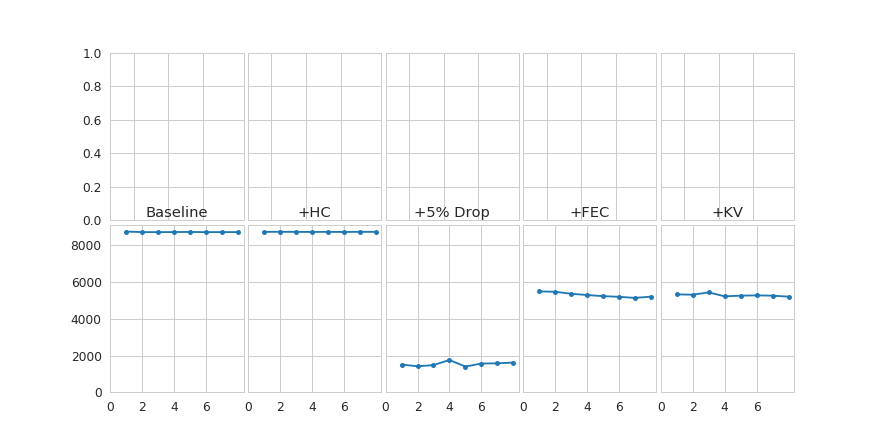

../tc7_output/tc7_cd_1/iperf/client_6.json: 0 intervals
../tc7_output/tc7_cd_2/iperf/client_1.json: 0 intervals
Malformed json ../tc7_output/tc7_cd_3/iperf/client_8.json: Expecting value: line 1 column 1 (char 0)
Retry succeeded
../tc7_output/tc7_cd_3/iperf/client_8.json: 9 intervals
../tc7_output/tc7_cd_4/iperf/client_5.json: 0 intervals
../tc7_output/tc7_cdf_4/iperf/client_2.json: 0 intervals
../tc7_output/tc7_cdfk_4/iperf/client_5.json: 0 intervals
../tc7_output/tc7_cdfk_1/iperf/client_2.json: 0 intervals
../tc7_output/tc7_cdfk_1/iperf/client_4.json: 0 intervals
Malformed json ../tc7_output/tc7_cdfk_2/iperf/client_7.json: Expecting value: line 1 column 1 (char 0)
Retry succeeded
../tc7_output/tc7_cdfk_2/iperf/client_7.json: 9 intervals
[1 2 3 4 5 6 7 8]
[8747.48398005 8719.63497346 8717.0561548  8722.78096935 8727.72444829
 8717.83686435 8720.03730117 8719.76266066]
[1 2 3 4 5 6 7 8]
[8730.44843994 8736.28916116 8731.40120399 8726.8358642  8732.22455866
 8725.83923221 8733.86717844 

<IPython.core.display.Javascript object>


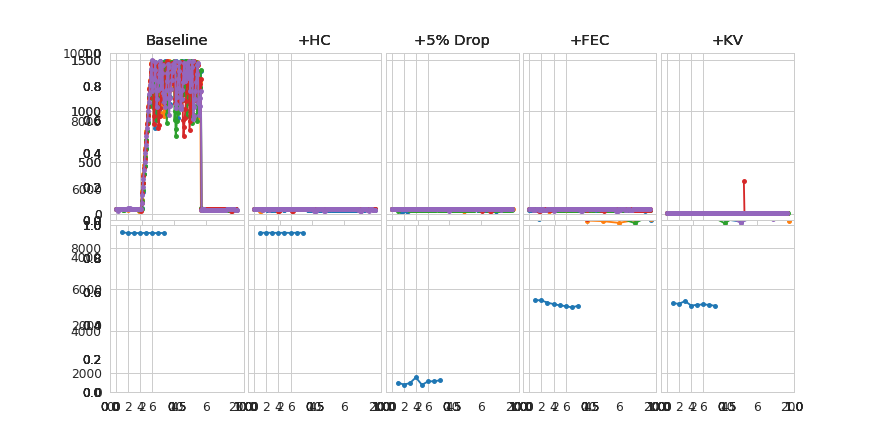

../tc7_output/tc7_cd_1/iperf/client_6.json: 0 intervals
../tc7_output/tc7_cd_2/iperf/client_1.json: 0 intervals
Malformed json ../tc7_output/tc7_cd_3/iperf/client_8.json: Expecting value: line 1 column 1 (char 0)
Retry succeeded
../tc7_output/tc7_cd_3/iperf/client_8.json: 9 intervals
../tc7_output/tc7_cd_4/iperf/client_5.json: 0 intervals
../tc7_output/tc7_cdf_4/iperf/client_2.json: 0 intervals
../tc7_output/tc7_cdfk_4/iperf/client_5.json: 0 intervals
../tc7_output/tc7_cdfk_1/iperf/client_2.json: 0 intervals
../tc7_output/tc7_cdfk_1/iperf/client_4.json: 0 intervals
Malformed json ../tc7_output/tc7_cdfk_2/iperf/client_7.json: Expecting value: line 1 column 1 (char 0)
Retry succeeded
../tc7_output/tc7_cdfk_2/iperf/client_7.json: 9 intervals


Text(0, 0.5, 'Throughput (Mbps)')

In [840]:
from glob import glob
from mpl_toolkits.axes_grid1 import Grid


def make_iperf_dicts(globdir, label):
    ds = []
    for i, dr in enumerate(glob(globdir)):
        d = dict( dir=dr, label=label)
        ds.append(d)
    return ds

def group_iperf_timeseries(groups):
    grid = Grid(plt.gcf(), rect=111, nrows_ncols=(1,len(groups)),
            axes_pad=.05, label_mode='L',
            )    
    
    for i, (ax, (label, tss)) in enumerate(zip(grid, groups.items())):
        plt.sca(ax)
        make_iperf_timeseries(tss)
        ax.set_title(label)
        ax.set_xticks([0,2,4,6])
        

def make_avg_iperf_timeseries(groups):
    
    grouped = defaultdict(list)
    for label, folders in groups.items():
        for folder in folders:
            ts = read_iperf_ts_directory(folder)
            if len(ts) == 10:
                grouped[label].append(ts)
        
    grid = Grid(plt.gcf(), rect=111, nrows_ncols=(1,len(grouped)),
            axes_pad=.05, label_mode='L',
            )    
        
    for i, (ax, (label, tss)) in enumerate(zip(grid, grouped.items())):
        ts = np.mean(tss, 0)
        x = np.arange(len(ts))
        print(x[1:-1])
        print(ts[1:-1])
        ax.plot(x[1:-1], ts[1:-1], '.-', label=label)
        ax.set_title(label)
        ax.set_xticks([0,2,4,6])
        

plt.figure(figsize=(10, 5))
make_avg_iperf_timeseries(tc7_files)
plt.ylim([0, None])
plt.ylabel("Throughput (Mbps)")

plt.figure(figsize=(10,5))
group_iperf_timeseries(tc7_files)
plt.ylim([0, 10000])
plt.ylabel("Throughput (Mbps)")

In [1320]:
import pandas as pd

def twin_plot_both(groups):
    sns.set_style("white")
    
    df = pd.DataFrame(columns=("Latency (uS)", "Label"))
    ax = plt.subplot()
    
    for label, folders in groups.items():
        for d in folders:
            tds = experiment_tds(d)
            df = df.append({
                'Latency (uS)': np.mean(tds[0][:,1]) * 1e6,
                'Label': label}, ignore_index=True)
    errs = df.groupby("Label").max() - df.groupby("Label").min()
    means = df.groupby("Label").mean()
    
    errs = df.groupby("Label").std()
    
    perr = errs / means
    
    
    sns.pointplot(x='Label', y='Latency (uS)', data=df, color=[0,0,0], label='Memcached Latency',ax=ax,)
    ax.set_ylabel(r"Latency ($\mu s$)")

    plt.yscale('log')
    plt.ylim([8, 1e3])
    
    ax2 = plt.twinx()
    
    df = pd.DataFrame(columns=("Throughput (Gbps)", "Label"))
    for label, folders in groups.items():
        
        for folder in folders:
            ts = read_iperf_ts_directory(folder)
            df = df.append({
                "Throughput (Gbps)": np.mean(ts) / 1024,
                'Label': label
            }, ignore_index=True)
    
    errs2 = df.groupby("Label").std()
    means2 =df.groupby("Label").mean()
    
    tp = sns.pointplot(x='Label', y='Throughput (Gbps)', data=df, ax=ax2, color=[.8,.8,.8],label='Iperf3 Throughput')
    tp = tp.get_children()[1]
    leg = ax2.legend(['Iperf3 Throughput'], loc='top right')
    ax2.set_ylabel("Throughput (Gbps)")
    leg = ax.legend(['Memcached Latency'], loc='bottom left', bbox_to_anchor=(.49,.15,0,0))
    
    return errs, errs2

def plot_stack(groups):
    sns.set_style("whitegrid")
    
    dd = OrderedDict()
    err = OrderedDict()
    
    grid = Grid(plt.gcf(), rect=111, nrows_ncols=(2,1),
            axes_pad=.05, label_mode='L',
            )   
    ax = grid[0]
    
    for label, folders in groups.items():
        vals = []
        for d in folders:
            tds = experiment_tds(d)
            vals.append(np.mean(tds[0][:,1]))
        dd[label] = np.mean(vals) * 1e6
        err[label] = max(vals) - min(vals)

    x = list(dd.keys())
    y = list(dd.values())
    
    ax.plot(x, y, '.-', markersize=15, color='k')
    ax.set_yscale('log')
    ax.set_ylim([8, 1e3])
    ax.set_ylabel(r"Latency ($\mu s$)")
    
    dd = OrderedDict()
    
    variance = []
    for label, folders in groups.items():
        vals = []
        for folder in folders:
            vals.append(np.mean(read_iperf_ts_directory(folder)) / 1024)
        dd[label] = np.mean(vals)
        
        
            
    x = list(dd.keys())
    y = list(dd.values())
    
    ax = grid[1]
    ax.plot(x, y, '.-', markersize=15, color='k')
    ax.set_ylabel("Throughput (Gbps)")
    ax.set_ylim([.5, 9.500])
    
    
    return perr    

def plot_both(groups):

    grid = Grid(plt.gcf(), rect=111, nrows_ncols=(2,len(groups)),
            axes_pad=.05, label_mode='L',
            )    
        
#     ax = plt.subplot(1, len(grouped), 1) 
    for i, (ax, (label, folders)) in enumerate(zip(grid[:len(groups)],groups.items())):
#         ax = plt.subplot(1, len(grouped), i+1, sharey=ax)
        plt.sca(ax)
        for d in folders:
            tds = experiment_tds(d)
            plot_rolling_timeseries(tds[0])
        ax.set_title(label)
        ax.set_yscale('log')
        ax.set_ylabel("Memcached Latency (uS)")
        ax.set_xticks([0,2,4,6])
        ax.set_xlim([1, 9])
    
            
    for i, (ax, (label, folders)) in enumerate(zip(grid[len(groups):], groups.items())):
        tss = []
        plt.sca(ax)
        make_iperf_timeseries(folders)

        ax.set_xticks([2,4,6,8])
        ax.set_ylabel("Iperf3 Throughput (Gbps)")
        ax.set_xlim([1, 9])


<IPython.core.display.Javascript object>


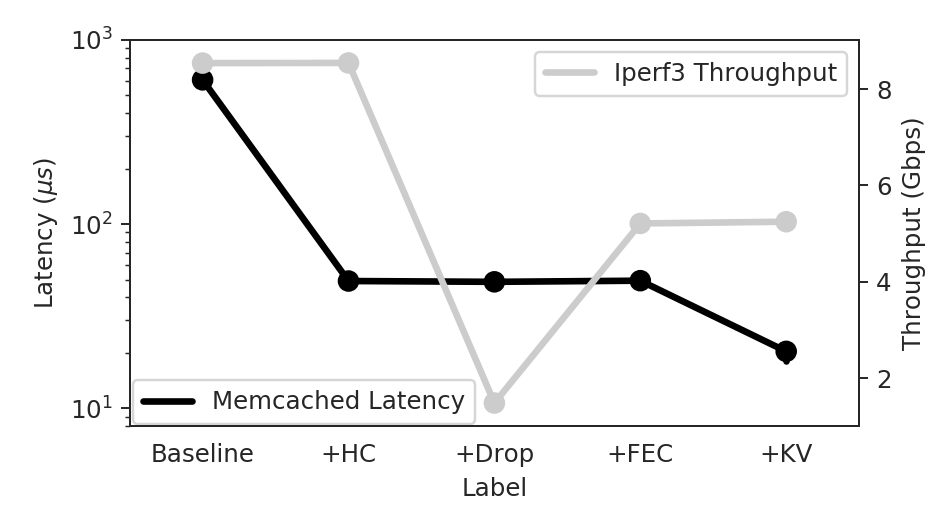

Loading from memo/tds/experiment_tds__directory-tc7_outputtc7_base_5.pickle
:: Cached stdout:
 :: Reading from directory ../tc7_output/tc7_base_5 :: 
 :: Reading ../tc7_output/tc7_base_5/moongen/moongen_in.pcap :: 
 :: 2000th set :: 
 :: 4000th set :: 
 :: 6000th set :: 
 :: 8000th set :: 
 :: 10000th set :: 
 :: 5000th get :: 
 :: 10000th get :: 
 :: 15000th get :: 
 :: 20000th get :: 
 :: 25000th get :: 
 :: 30000th get :: 
 :: 35000th get :: 
 :: 40000th get :: 
 :: 45000th get :: 
 :: 50000th get :: 
 :: 55000th get :: 
 :: 60000th get :: 
 :: 65000th get :: 
 :: 70000th get :: 
 :: 75000th get :: 
 :: 80000th get :: 
 :: 85000th get :: 
 :: 90000th get :: 
 :: 95000th get :: 
 :: 100000th get :: 
 :: 105000th get :: 
 :: 110000th get :: 
 :: 115000th get :: 
 :: 120000th get :: 
 :: 125000th get :: 
 :: 130000th get :: 
 :: 135000th get :: 
 :: 140000th get :: 
 :: 145000th get :: 
 :: 150000th get :: 
 :: 155000th get :: 
 :: 160000th get :: 
 :: 165000th get :: 
 :: 170000th get

../tc7_output/tc7_cd_1/iperf/client_6.json: 0 intervals
../tc7_output/tc7_cd_2/iperf/client_1.json: 0 intervals
Malformed json ../tc7_output/tc7_cd_3/iperf/client_8.json: Expecting value: line 1 column 1 (char 0)
Retry succeeded
../tc7_output/tc7_cd_3/iperf/client_8.json: 9 intervals
../tc7_output/tc7_cd_4/iperf/client_5.json: 0 intervals
../tc7_output/tc7_cdf_4/iperf/client_2.json: 0 intervals
../tc7_output/tc7_cdfk_4/iperf/client_5.json: 0 intervals
../tc7_output/tc7_cdfk_1/iperf/client_2.json: 0 intervals
../tc7_output/tc7_cdfk_1/iperf/client_4.json: 0 intervals
Malformed json ../tc7_output/tc7_cdfk_2/iperf/client_7.json: Expecting value: line 1 column 1 (char 0)
Retry succeeded
../tc7_output/tc7_cdfk_2/iperf/client_7.json: 9 intervals
Memcached Standard Deviations:
          Latency (uS)
Label                 
+Drop         3.256924
+FEC          3.119679
+HC           2.242648
+KV           2.691345
Baseline      7.024733
iperf standard deviations:
          Throughput (Gbps)
Labe

In [1325]:
plt.figure(figsize=(5.4, 3))

variances = twin_plot_both(tc7_files)
plt.tight_layout()
# plt.tight_layout()
plt.savefig("e2e_twin.pdf")
print("Memcached Standard Deviations:\n%s\niperf standard deviations:\n%s"%variances)

<IPython.core.display.Javascript object>


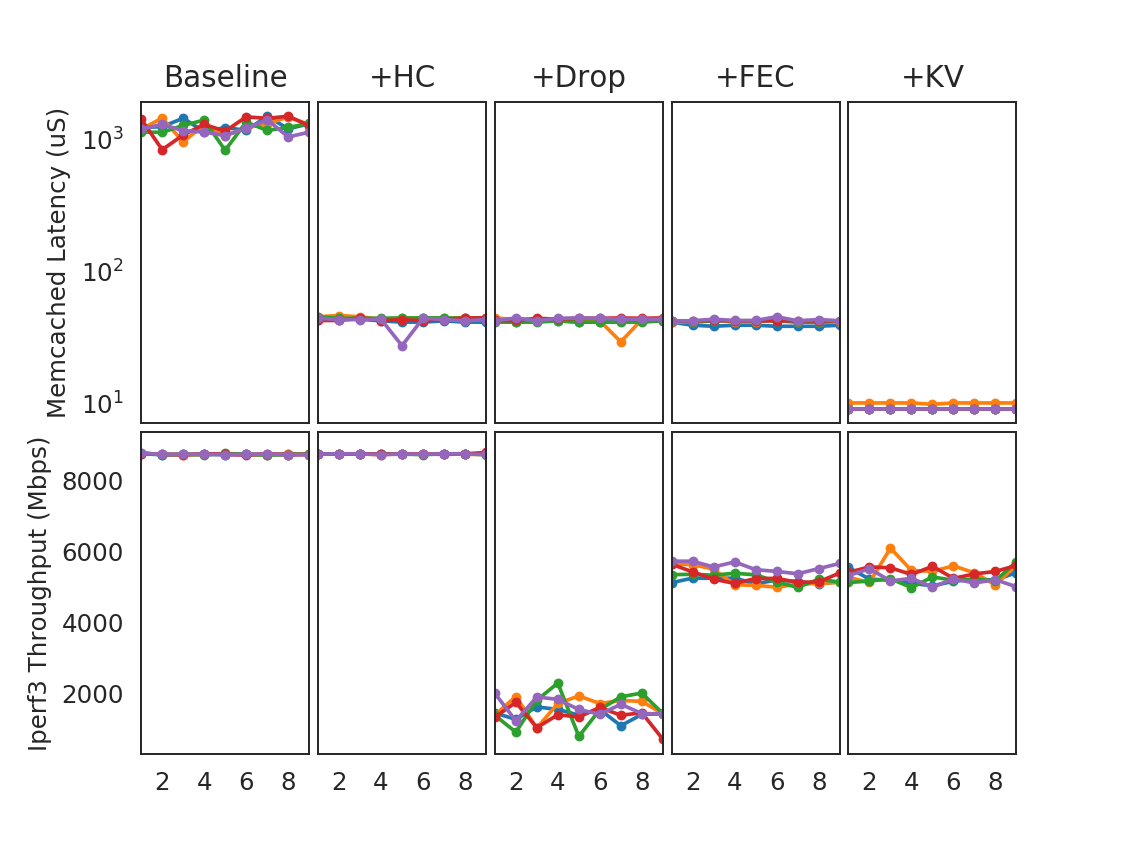

Loading from memo/tds/experiment_tds__directory-tc7_outputtc7_base_5.pickle
:: Cached stdout:
 :: Reading from directory ../tc7_output/tc7_base_5 :: 
 :: Reading ../tc7_output/tc7_base_5/moongen/moongen_in.pcap :: 
 :: 2000th set :: 
 :: 4000th set :: 
 :: 6000th set :: 
 :: 8000th set :: 
 :: 10000th set :: 
 :: 5000th get :: 
 :: 10000th get :: 
 :: 15000th get :: 
 :: 20000th get :: 
 :: 25000th get :: 
 :: 30000th get :: 
 :: 35000th get :: 
 :: 40000th get :: 
 :: 45000th get :: 
 :: 50000th get :: 
 :: 55000th get :: 
 :: 60000th get :: 
 :: 65000th get :: 
 :: 70000th get :: 
 :: 75000th get :: 
 :: 80000th get :: 
 :: 85000th get :: 
 :: 90000th get :: 
 :: 95000th get :: 
 :: 100000th get :: 
 :: 105000th get :: 
 :: 110000th get :: 
 :: 115000th get :: 
 :: 120000th get :: 
 :: 125000th get :: 
 :: 130000th get :: 
 :: 135000th get :: 
 :: 140000th get :: 
 :: 145000th get :: 
 :: 150000th get :: 
 :: 155000th get :: 
 :: 160000th get :: 
 :: 165000th get :: 
 :: 170000th get

Loading from memo/tds/experiment_tds__directory-tc7_outputtc7_base_1.pickle
:: Cached stdout:
 :: Reading from directory ../tc7_output/tc7_base_1 :: 
 :: Reading ../tc7_output/tc7_base_1/moongen/moongen_in.pcap :: 
 :: 2000th set :: 
 :: 4000th set :: 
 :: 6000th set :: 
 :: 8000th set :: 
 :: 10000th set :: 
 :: 5000th get :: 
 :: 10000th get :: 
 :: 15000th get :: 
 :: 20000th get :: 
 :: 25000th get :: 
 :: 30000th get :: 
 :: 35000th get :: 
 :: 40000th get :: 
 :: 45000th get :: 
 :: 50000th get :: 
 :: 55000th get :: 
 :: 60000th get :: 
 :: 65000th get :: 
 :: 70000th get :: 
 :: 75000th get :: 
 :: 80000th get :: 
 :: 85000th get :: 
 :: 90000th get :: 
 :: 95000th get :: 
 :: 100000th get :: 
 :: 105000th get :: 
 :: 110000th get :: 
 :: 115000th get :: 
 :: 120000th get :: 
 :: 125000th get :: 
 :: 130000th get :: 
 :: 135000th get :: 
 :: 140000th get :: 
 :: 145000th get :: 
 :: 150000th get :: 
 :: 155000th get :: 
 :: 160000th get :: 
 :: 165000th get :: 
 :: 170000th get

Loading from memo/tds/experiment_tds__directory-tc7_outputtc7_c_3.pickle
:: Cached stdout:
 :: Reading from directory ../tc7_output/tc7_c_3 :: 
 :: Reading ../tc7_output/tc7_c_3/moongen/moongen_in.pcap :: 
 :: 2000th set :: 
 :: 4000th set :: 
 :: 6000th set :: 
 :: 8000th set :: 
 :: 10000th set :: 
 :: 5000th get :: 
 :: 10000th get :: 
 :: 15000th get :: 
 :: 20000th get :: 
 :: 25000th get :: 
 :: 30000th get :: 
 :: 35000th get :: 
 :: 40000th get :: 
 :: 45000th get :: 
 :: 50000th get :: 
 :: 55000th get :: 
 :: 60000th get :: 
 :: 65000th get :: 
 :: 70000th get :: 
 :: 75000th get :: 
 :: 80000th get :: 
 :: 85000th get :: 
 :: 90000th get :: 
 :: 95000th get :: 
 :: 100000th get :: 
 :: 105000th get :: 
 :: 110000th get :: 
 :: 115000th get :: 
 :: 120000th get :: 
 :: 125000th get :: 
 :: 130000th get :: 
 :: 135000th get :: 
 :: 140000th get :: 
 :: 145000th get :: 
 :: 150000th get :: 
 :: 155000th get :: 
 :: 160000th get :: 
 :: 165000th get :: 
 :: 170000th get :: 
 :: 

Loading from memo/tds/experiment_tds__directory-tc7_outputtc7_cd_2.pickle
:: Cached stdout:
 :: Reading from directory ../tc7_output/tc7_cd_2 :: 
 :: Reading ../tc7_output/tc7_cd_2/moongen/moongen_in.pcap :: 
 :: 2000th set :: 
 :: 4000th set :: 
 :: 6000th set :: 
 :: 8000th set :: 
 :: 10000th set :: 
 :: 5000th get :: 
 :: 10000th get :: 
 :: 15000th get :: 
 :: 20000th get :: 
 :: 25000th get :: 
 :: 30000th get :: 
 :: 35000th get :: 
 :: 40000th get :: 
 :: 45000th get :: 
 :: 50000th get :: 
 :: 55000th get :: 
 :: 60000th get :: 
 :: 65000th get :: 
 :: 70000th get :: 
 :: 75000th get :: 
 :: 80000th get :: 
 :: 85000th get :: 
 :: 90000th get :: 
 :: 95000th get :: 
 :: 100000th get :: 
 :: 105000th get :: 
 :: 110000th get :: 
 :: 115000th get :: 
 :: 120000th get :: 
 :: 125000th get :: 
 :: 130000th get :: 
 :: 135000th get :: 
 :: 140000th get :: 
 :: 145000th get :: 
 :: 150000th get :: 
 :: 155000th get :: 
 :: 160000th get :: 
 :: 165000th get :: 
 :: 170000th get :: 
 

Loading from memo/tds/experiment_tds__directory-tc7_outputtc7_cdf_3.pickle
:: Cached stdout:
 :: Reading from directory ../tc7_output/tc7_cdf_3 :: 
 :: Reading ../tc7_output/tc7_cdf_3/moongen/moongen_in.pcap :: 
 :: 2000th set :: 
 :: 4000th set :: 
 :: 6000th set :: 
 :: 8000th set :: 
 :: 10000th set :: 
 :: 5000th get :: 
 :: 10000th get :: 
 :: 15000th get :: 
 :: 20000th get :: 
 :: 25000th get :: 
 :: 30000th get :: 
 :: 35000th get :: 
 :: 40000th get :: 
 :: 45000th get :: 
 :: 50000th get :: 
 :: 55000th get :: 
 :: 60000th get :: 
 :: 65000th get :: 
 :: 70000th get :: 
 :: 75000th get :: 
 :: 80000th get :: 
 :: 85000th get :: 
 :: 90000th get :: 
 :: 95000th get :: 
 :: 100000th get :: 
 :: 105000th get :: 
 :: 110000th get :: 
 :: 115000th get :: 
 :: 120000th get :: 
 :: 125000th get :: 
 :: 130000th get :: 
 :: 135000th get :: 
 :: 140000th get :: 
 :: 145000th get :: 
 :: 150000th get :: 
 :: 155000th get :: 
 :: 160000th get :: 
 :: 165000th get :: 
 :: 170000th get ::

Loading from memo/tds/experiment_tds__directory-tc7_outputtc7_cdfk_3.pickle
:: Cached stdout:
 :: Reading from directory ../tc7_output/tc7_cdfk_3 :: 
 :: Reading ../tc7_output/tc7_cdfk_3/moongen/moongen_in.pcap :: 
 :: 2000th set :: 
 :: 4000th set :: 
 :: 6000th set :: 
 :: 8000th set :: 
 :: 10000th set :: 
 :: 5000th get :: 
 :: 10000th get :: 
 :: 15000th get :: 
 :: 20000th get :: 
 :: 25000th get :: 
 :: 30000th get :: 
 :: 35000th get :: 
 :: 40000th get :: 
 :: 45000th get :: 
 :: 50000th get :: 
 :: 55000th get :: 
 :: 60000th get :: 
 :: 65000th get :: 
 :: 70000th get :: 
 :: 75000th get :: 
 :: 80000th get :: 
 :: 85000th get :: 
 :: 90000th get :: 
 :: 95000th get :: 
 :: 100000th get :: 
 :: 105000th get :: 
 :: 110000th get :: 
 :: 115000th get :: 
 :: 120000th get :: 
 :: 125000th get :: 
 :: 130000th get :: 
 :: 135000th get :: 
 :: 140000th get :: 
 :: 145000th get :: 
 :: 150000th get :: 
 :: 155000th get :: 
 :: 160000th get :: 
 :: 165000th get :: 
 :: 170000th get

Loading from memo/tds/experiment_tds__directory-tc7_outputtc7_cdfk_2.pickle
:: Cached stdout:
 :: Reading from directory ../tc7_output/tc7_cdfk_2 :: 
 :: Reading ../tc7_output/tc7_cdfk_2/moongen/moongen_in.pcap :: 
 :: 2000th set :: 
 :: 4000th set :: 
 :: 6000th set :: 
 :: 8000th set :: 
 :: 10000th set :: 
 :: 5000th get :: 
 :: 10000th get :: 
 :: 15000th get :: 
 :: 20000th get :: 
 :: 25000th get :: 
 :: 30000th get :: 
 :: 35000th get :: 
 :: 40000th get :: 
 :: 45000th get :: 
 :: 50000th get :: 
 :: 55000th get :: 
 :: 60000th get :: 
 :: 65000th get :: 
 :: 70000th get :: 
 :: 75000th get :: 
 :: 80000th get :: 
 :: 85000th get :: 
 :: 90000th get :: 
 :: 95000th get :: 
 :: 100000th get :: 
 :: 105000th get :: 
 :: 110000th get :: 
 :: 115000th get :: 
 :: 120000th get :: 
 :: 125000th get :: 
 :: 130000th get :: 
 :: 135000th get :: 
 :: 140000th get :: 
 :: 145000th get :: 
 :: 150000th get :: 
 :: 155000th get :: 
 :: 160000th get :: 
 :: 165000th get :: 
 :: 170000th get

In [1109]:
plt.figure()
plot_both(tc7_files)
plt.savefig("e2e.pdf")